In [715]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as scp
import skimage
import torch

from defocus import Microscope

In [716]:
# knowns
WAVELENGTH = 405e-9
R_INDEX = 1
BEAM_WAIST = 200e-9
NA = 0.95
MAGNIFICATION = 1
PIXEL_SIZE = 200e-9

KERNEL_SIZE = 64

IMAGE_SIZE = 200
NOISE = 0.001
EMITTER_DENSITY = 0.0001

In [717]:
# laser PSF


def gaussian_beam(r, z):
    z_r = math.pi * (BEAM_WAIST**2) * R_INDEX / WAVELENGTH
    w = BEAM_WAIST * math.sqrt(1 + (z / z_r) ** 2)
    return (BEAM_WAIST / w) * math.exp(-(r**2) / (w**2))


def laser_psf(defocus: float, size: int):
    psf = torch.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = i - (size - 1) / 2
            y = j - (size - 1) / 2
            r = math.sqrt(x**2 + y**2)
            psf[j, i] = gaussian_beam(r * PIXEL_SIZE, defocus)
    return psf

In [718]:
# microscope PSF


def microscope_psf(defocus: float, size: int):
    scope = Microscope(
        dim=size * 4,
        NA=NA,
        mag=MAGNIFICATION,
        wavelength=WAVELENGTH,
        pixel_size=PIXEL_SIZE,
        device=torch.device("cpu"),
    )
    a = int(size * 1.5)
    return torch.tensor(scope.get_psf(defocus))[a : a + size, a : a + size]

/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/1161854432.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(scope.get_psf(defocus))[a : a + size, a : a + size]
/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/2076972097.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  captured_image = torch.nn.functional.conv2d(


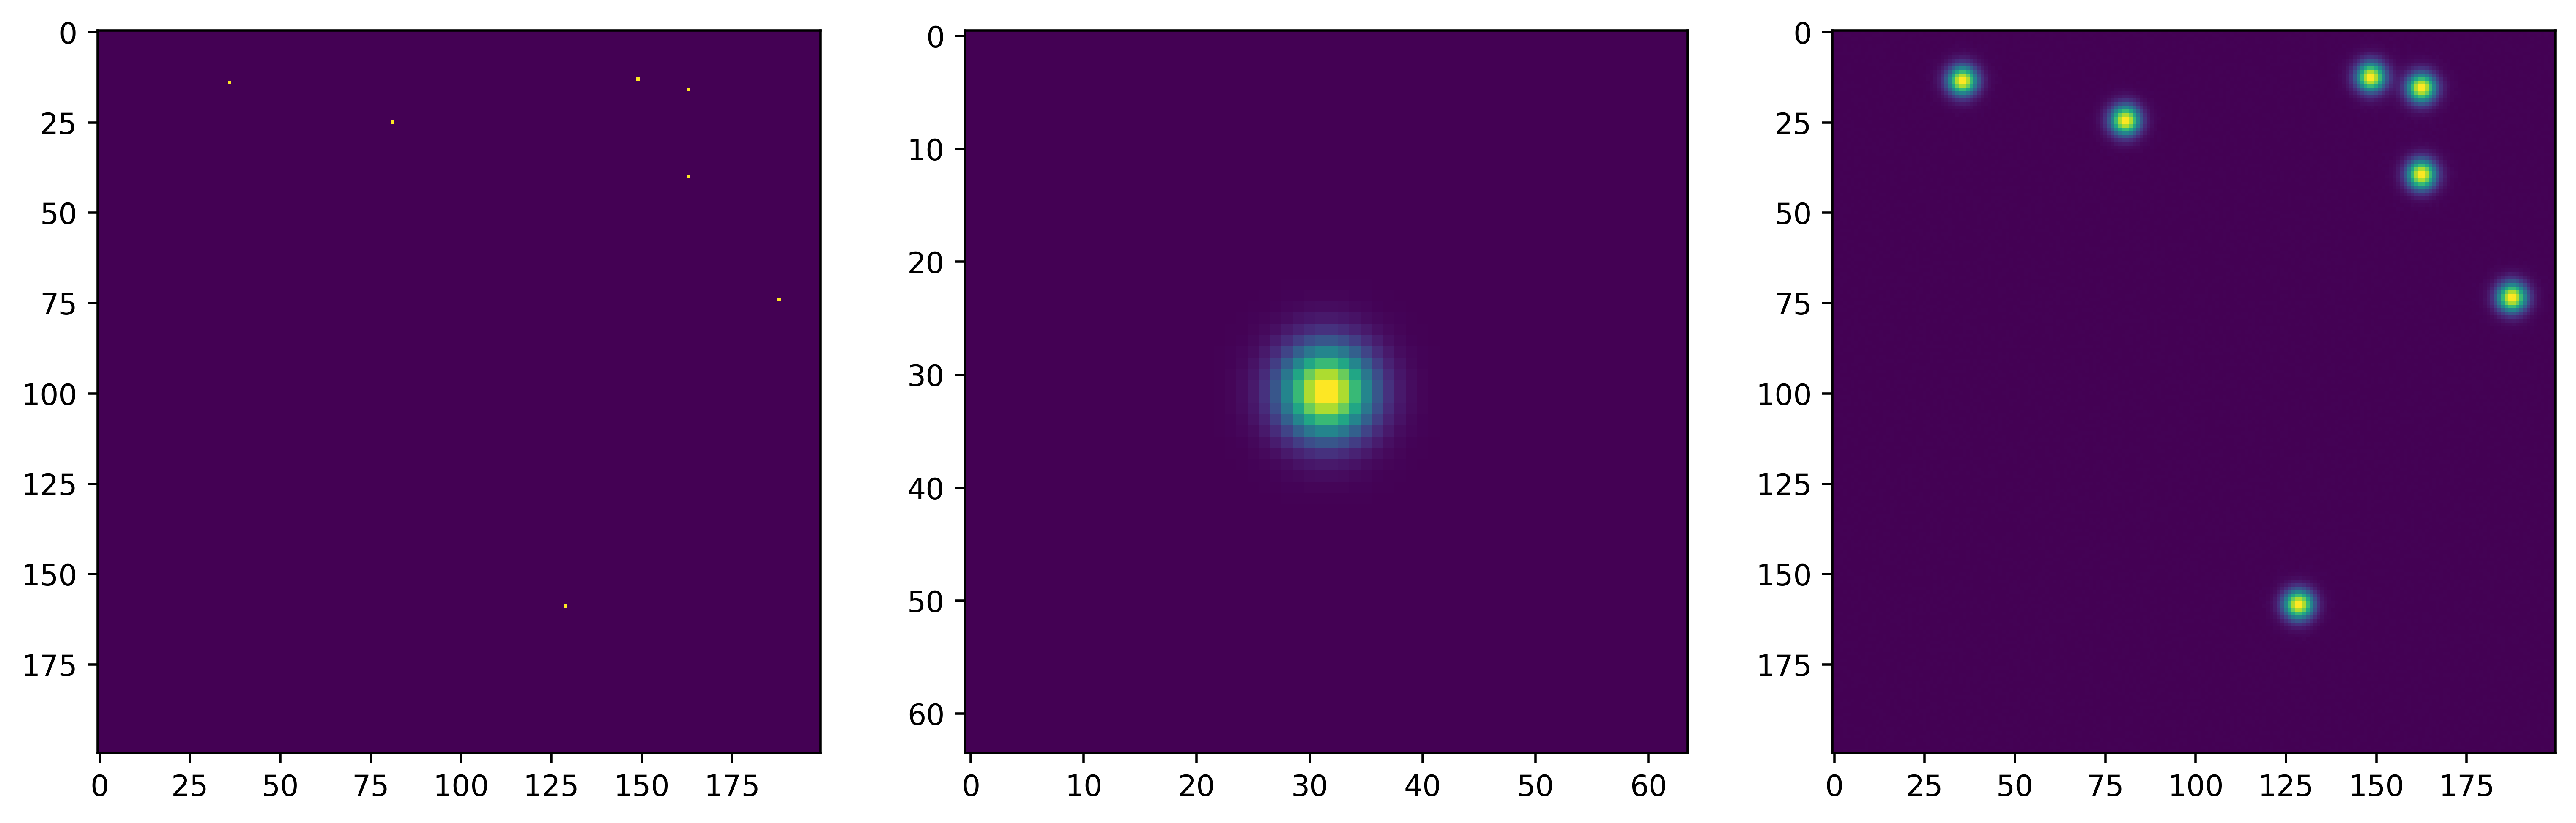

In [719]:
# generate ground truth image, "captured image"

np.random.seed(0)

# we're guessing this value
defocus = WAVELENGTH * 2


image = torch.tensor(
    np.random.choice(
        [0, 1],
        size=(IMAGE_SIZE, IMAGE_SIZE),
        p=[1 - EMITTER_DENSITY, EMITTER_DENSITY],
    )
).float()

psf = (
    torch.nn.functional.conv2d(
        microscope_psf(defocus, KERNEL_SIZE).unsqueeze(0).unsqueeze(0),
        laser_psf(defocus, KERNEL_SIZE).unsqueeze(0).unsqueeze(0),
        padding="same",
    )
    .squeeze(0)
    .squeeze(0)
)

captured_image = torch.nn.functional.conv2d(
    image.unsqueeze(0).unsqueeze(0), psf.unsqueeze(0).unsqueeze(0), padding="same"
).squeeze(0).squeeze(0) + NOISE * np.random.uniform(0, 1, size=(IMAGE_SIZE, IMAGE_SIZE))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(psf)
plt.subplot(1, 3, 3)
plt.imshow(captured_image)

In [720]:
### --- PRETEND WE DONT KNOW ANYTHING --- ###

BOX_SIZE = 10
KERNEL_SIZE2 = BOX_SIZE * 2


def error(img, defocus):
    scope = Microscope(
        dim=KERNEL_SIZE2 * 4,
        NA=NA,
        mag=MAGNIFICATION,
        wavelength=WAVELENGTH,
        pixel_size=PIXEL_SIZE,
        device=torch.device("cpu"),
    )
    a = int(KERNEL_SIZE2 * 1.5)
    psf1 = scope.get_psf(defocus)[a : a + KERNEL_SIZE2, a : a + KERNEL_SIZE2]
    psf2 = laser_psf(defocus, KERNEL_SIZE2)

    # return torch.sqrt(
    #     torch.sum(
    #         (
    #             img
    #             - torch.nn.functional.conv2d(
    #                 psf1.unsqueeze(0).unsqueeze(0), psf2.unsqueeze(0).unsqueeze(0)
    #             )
    #             .squeeze(0)
    #             .squeeze(0)
    #         )
    #         ** 2
    #     )
    # )
    return torch.sqrt(torch.sum((img - psf1) ** 2))


captured_image_cut = torch.clone(captured_image)
captured_image_cut[0:BOX_SIZE, :] = 0
captured_image_cut[-BOX_SIZE:-1, :] = 0
captured_image_cut[:, 0:BOX_SIZE] = 0
captured_image_cut[:, -BOX_SIZE:-1] = 0

max_i, max_j = torch.unravel_index(
    torch.argmax(captured_image_cut), captured_image_cut.shape
)
captured_psf = captured_image[
    max_i - BOX_SIZE : max_i + BOX_SIZE, max_j - BOX_SIZE + 1 : max_j + BOX_SIZE + 1
]

psf_grad = torch.func.grad(error, argnums=1)

defocus = 0.0

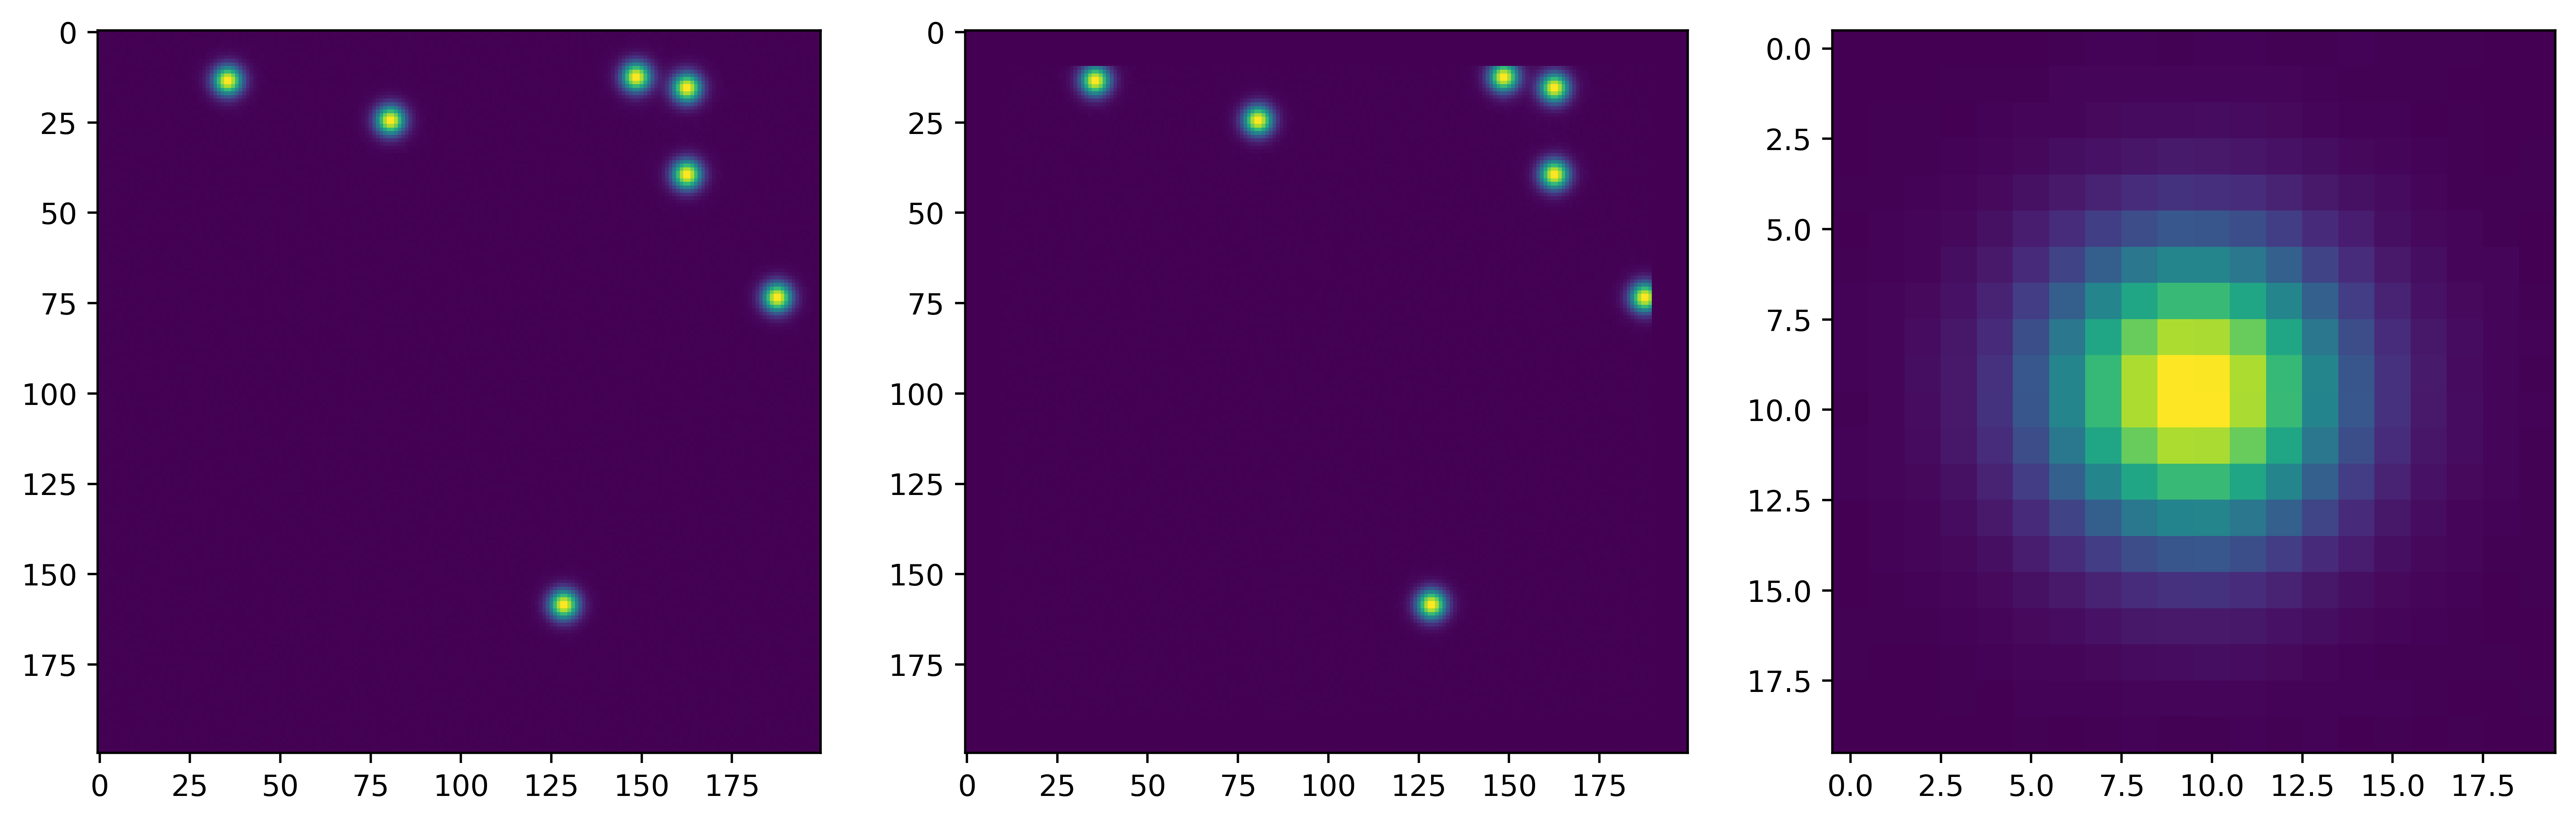

In [721]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(captured_image)
plt.subplot(1, 3, 2)
plt.imshow(captured_image_cut)
plt.subplot(1, 3, 3)
plt.imshow(captured_psf)

In [722]:
defocus = WAVELENGTH
learning_rate = 1e-13

for i in range(300):
    loss = error(torch.tensor(captured_psf), defocus)
    grad = psf_grad(torch.tensor(captured_psf), torch.tensor(defocus))
    defocus = defocus - learning_rate * grad
    print(defocus, loss, grad)

defocus

/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/1144743602.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = error(torch.tensor(captured_psf), defocus)
/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/1144743602.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad = psf_grad(torch.tensor(captured_psf), torch.tensor(defocus))


tensor(4.4756e-07) tensor(0.7674, dtype=torch.float64) tensor(-425562.2500)
tensor(4.8015e-07) tensor(0.7514, dtype=torch.float64) tensor(-325903.8438)
tensor(5.0501e-07) tensor(0.7420, dtype=torch.float64) tensor(-248675.8594)
tensor(5.2425e-07) tensor(0.7365, dtype=torch.float64) tensor(-192384.2344)
tensor(5.3941e-07) tensor(0.7332, dtype=torch.float64) tensor(-151574.9062)
tensor(5.5156e-07) tensor(0.7312, dtype=torch.float64) tensor(-121537.1875)
tensor(5.6146e-07) tensor(0.7298, dtype=torch.float64) tensor(-98961.2734)
tensor(5.6962e-07) tensor(0.7289, dtype=torch.float64) tensor(-81633.5234)
tensor(5.7643e-07) tensor(0.7283, dtype=torch.float64) tensor(-68077.2344)
tensor(5.8216e-07) tensor(0.7279, dtype=torch.float64) tensor(-57291.4883)
tensor(5.8702e-07) tensor(0.7276, dtype=torch.float64) tensor(-48584.2617)
tensor(5.9117e-07) tensor(0.7274, dtype=torch.float64) tensor(-41466.0938)
tensor(5.9472e-07) tensor(0.7272, dtype=torch.float64) tensor(-35583.9727)
tensor(5.9779e-07) 

tensor(6.1960e-07)

/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/1161854432.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(scope.get_psf(defocus))[a : a + size, a : a + size]
/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/3552355135.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(captured_image), np.array(recovered_psf), 100


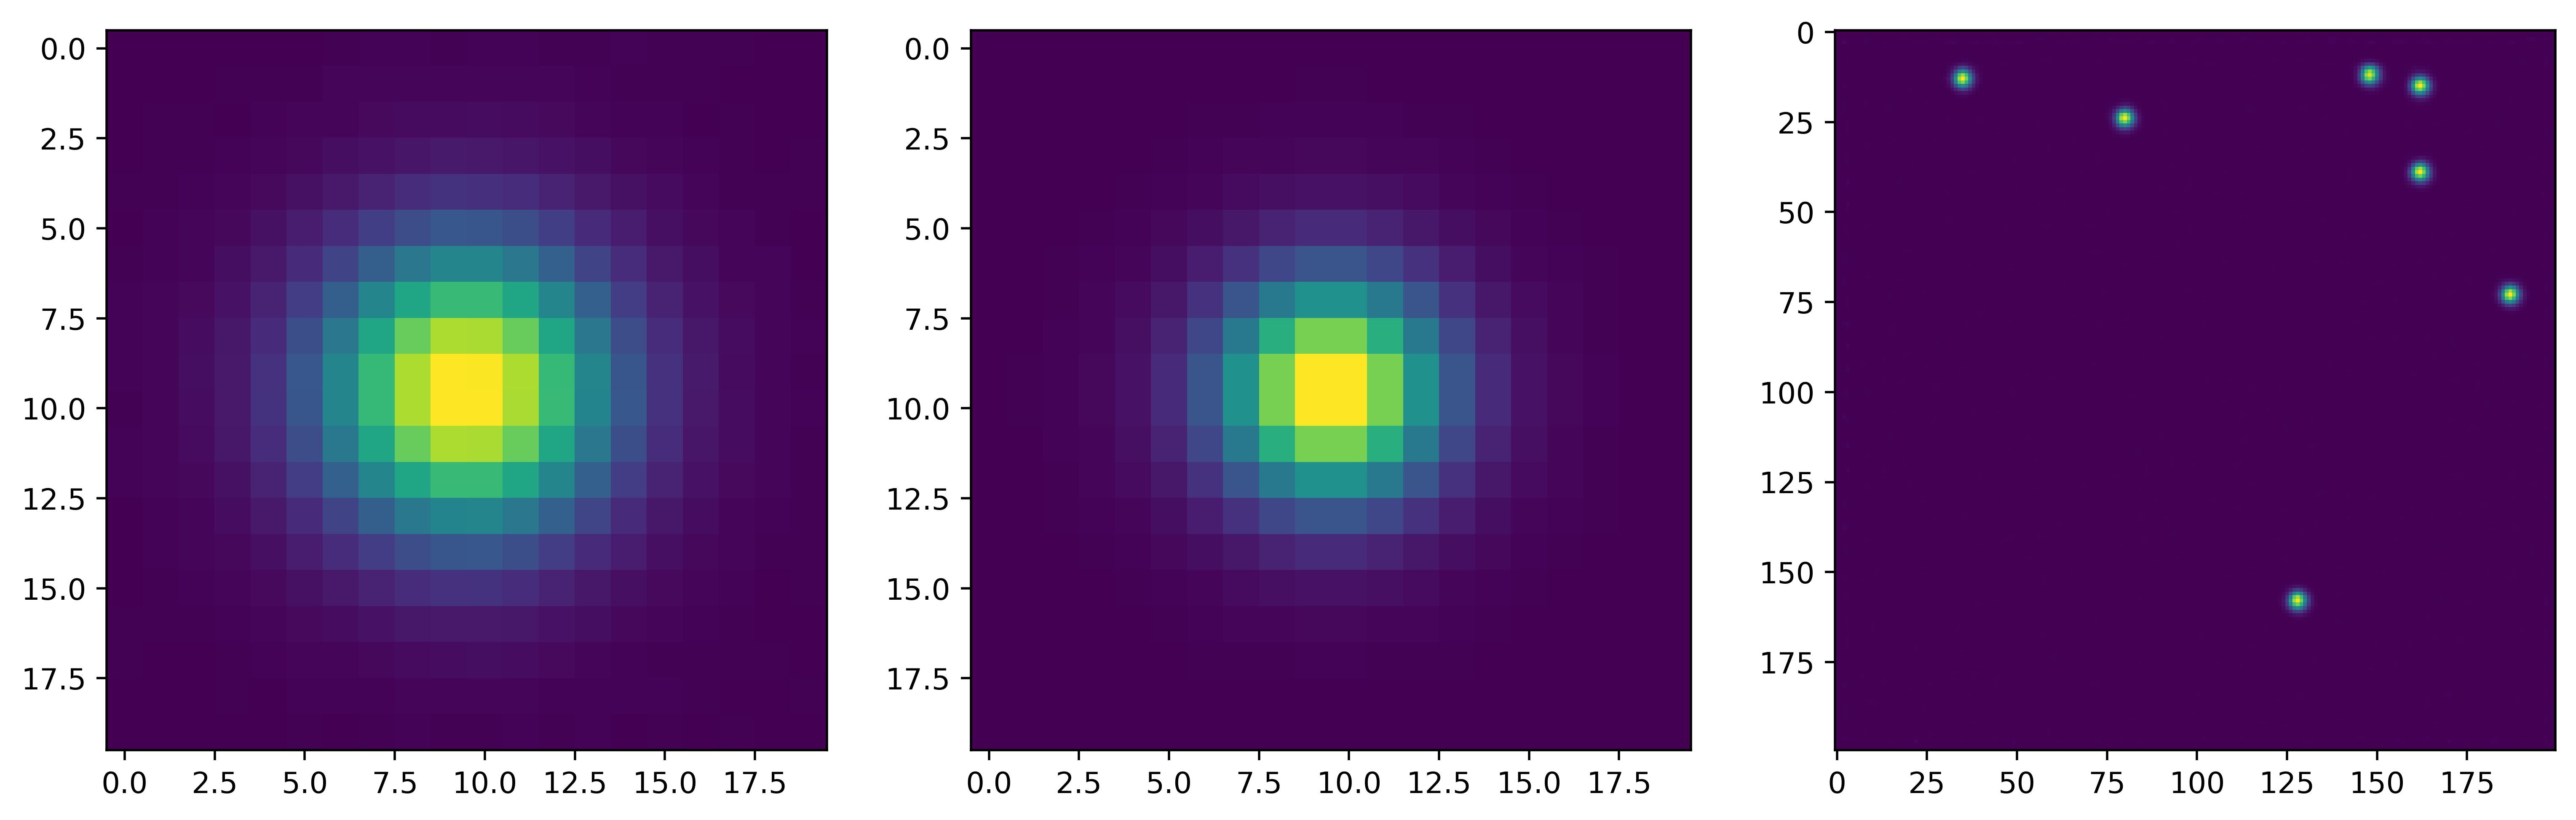

In [723]:
recovered_psf = (
    torch.nn.functional.conv2d(
        microscope_psf(defocus, KERNEL_SIZE2).unsqueeze(0).unsqueeze(0),
        laser_psf(defocus, KERNEL_SIZE2).unsqueeze(0).unsqueeze(0),
        padding="same",
    )
    .squeeze(0)
    .squeeze(0)
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(captured_psf)
plt.subplot(1, 3, 2)
plt.imshow(recovered_psf)
plt.subplot(1, 3, 3)
plt.imshow(
    skimage.restoration.richardson_lucy(
        np.array(captured_image), np.array(recovered_psf), 100
    )
)

/var/folders/xn/wg6r_v_14hngld2fhd428m780000gn/T/ipykernel_50406/3834885600.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(captured_image), np.array(recovered_psf), 100


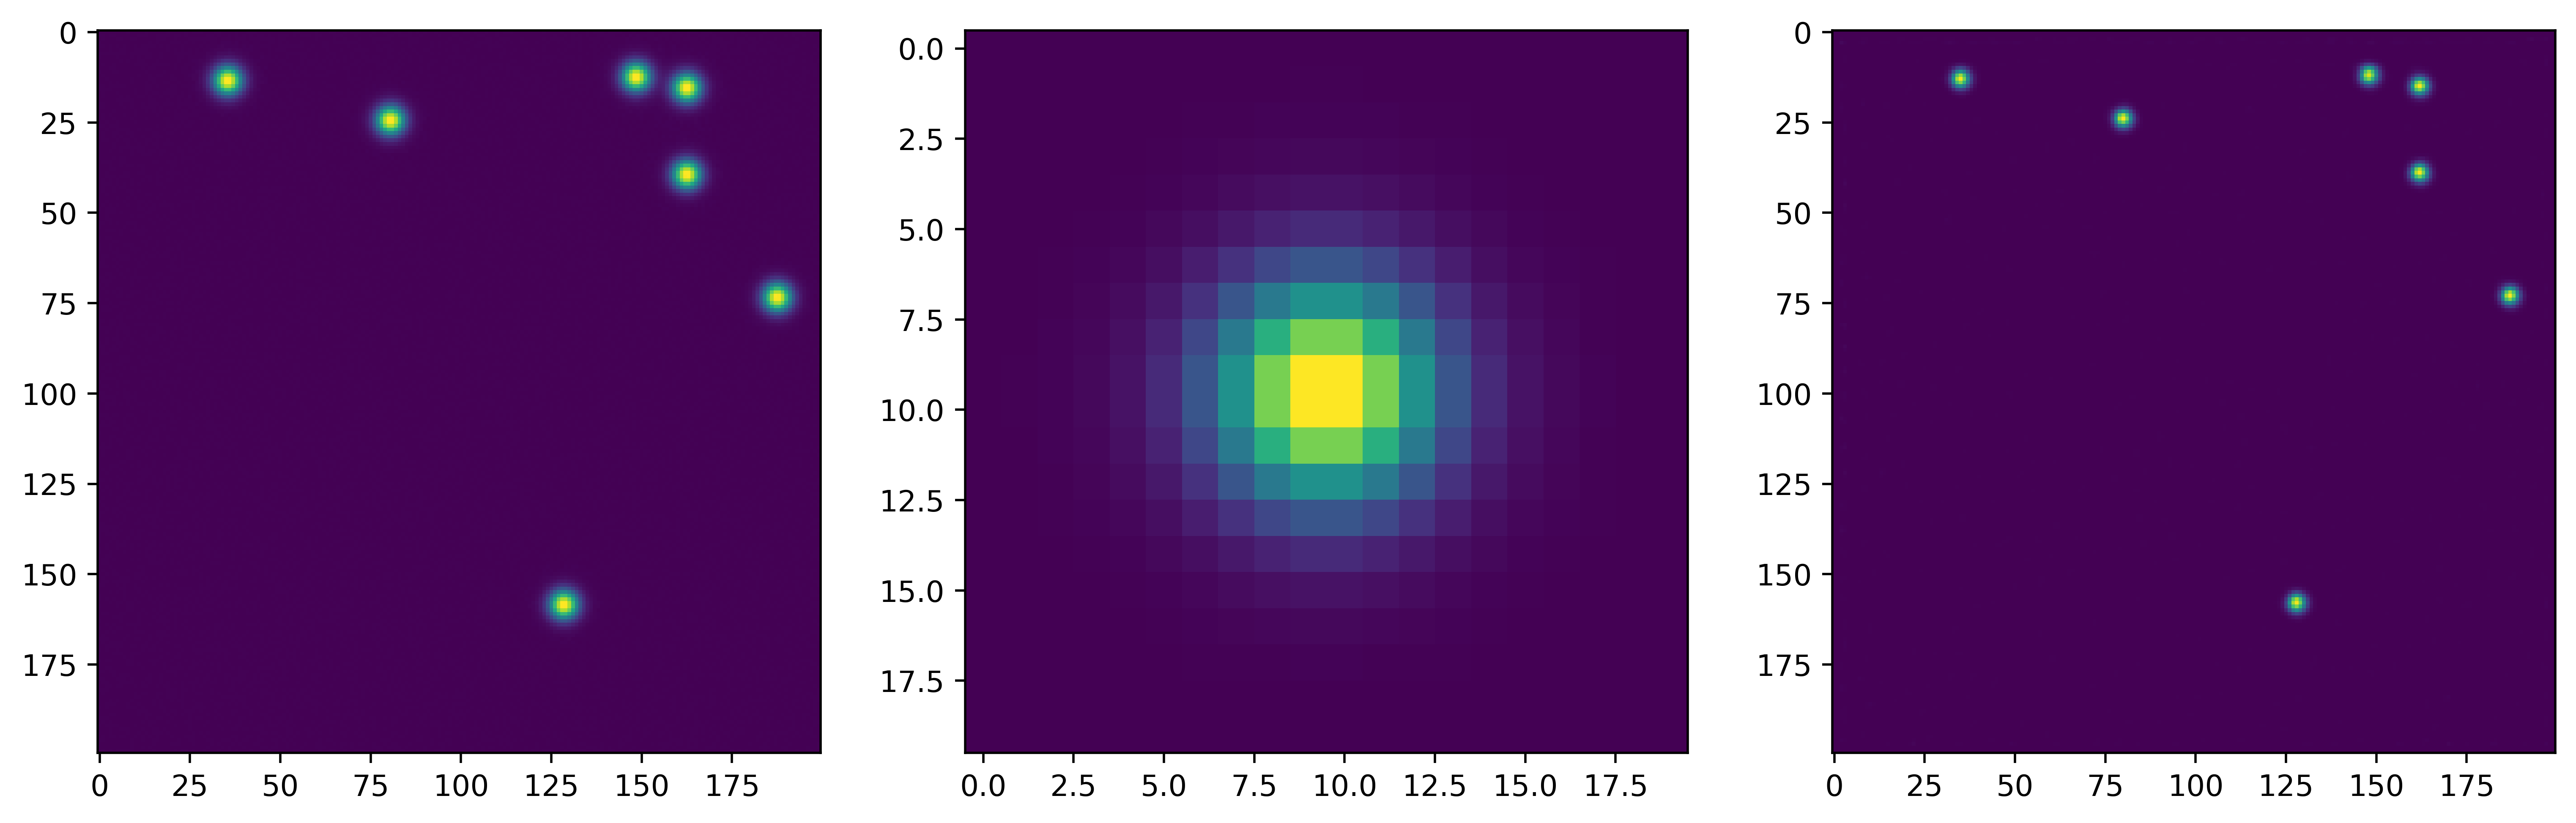

In [724]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(captured_image)
plt.subplot(1, 3, 2)
plt.imshow(recovered_psf)
plt.subplot(1, 3, 3)
plt.imshow(
    skimage.restoration.richardson_lucy(
        np.array(captured_image), np.array(recovered_psf), 100
    )
)